In [1]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import umap

from sklearn.metrics import (
    roc_curve, auc
)

from cytoemd import CytoEMD
from collections import OrderedDict, defaultdict
from anndata import read_h5ad, AnnData
from time import time

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
adata = read_h5ad("../data/aml.h5ad")
marker_in_use = ['IgG1-FITC','IgG1-PE','CD45-ECD-1','IgG1-PC5','IgG1-PC7','CD45-ECD-2','CD19-PC5','CD20-PC7',
              'CD7-FITC','CD4-PE','CD45-ECD-3','CD8-PC5','CD2-PC7','CD15-FITC','CD13-PE','CD45-ECD-4',
              'CD16-PC5','CD56-PC7','CD14-FITC','CD11c-PE','CD45-ECD-5','CD64-PC5','CD33-PC7','HLA-DR-FITC',
              'CD117-PE','CD45-ECD-6','CD34-PC5','CD38-PC7','CD5-FITC','CD19-PE','CD45-ECD-7','CD3-PC5','CD10-PC7']
adata.var.index = adata.var['pns_label']
adata.var.index.name = 'index'
adata = adata[:,marker_in_use]

co_factor = 5.
# set seed for reproducibility
seed = 0
N = 100

adata.X = np.arcsinh(adata.X / co_factor)

In [3]:
adata.obs.head()

,FCS_file,Individual,Condition
1-1,0001.FCS,1,normal
1-2,0001.FCS,1,normal
1-3,0001.FCS,1,normal
1-4,0001.FCS,1,normal
1-5,0001.FCS,1,normal


In [4]:
adata_list = [adata[adata.obs['FCS_file'] == sample, :] for sample in adata.obs['FCS_file'].unique()]
sample_meta_list = [_adata.obs[['FCS_file', 'Individual', 'Condition']].iloc[0].T for _adata in adata_list]
sample_meta = pd.concat(sample_meta_list, axis=1).T

### Subsample Cells

In [5]:
adata_list_1k = [sc.pp.subsample(adata, random_state=0, n_obs=1000, copy=True) for adata in adata_list[:N]]
adata_list_2k = [sc.pp.subsample(adata, random_state=0, n_obs=2000, copy=True) for adata in adata_list[:N]]
adata_list_3k = [sc.pp.subsample(adata, random_state=0, n_obs=3000, copy=True) for adata in adata_list[:N]]
adata_list_4k = [sc.pp.subsample(adata, random_state=0, n_obs=4000, copy=True) for adata in adata_list[:N]]
adata_list_5k = [sc.pp.subsample(adata, random_state=0, n_obs=5000, copy=True) for adata in adata_list[:N]]
adata_list_8k = [sc.pp.subsample(adata, random_state=0, n_obs=8000, copy=True) for adata in adata_list[:N]]

subsample_adata_list = [adata_list_1k, adata_list_2k, adata_list_3k, adata_list_4k, adata_list_5k, adata_list_8k]

### CPU=1

In [6]:
timing_res = defaultdict(list)

for _adata in subsample_adata_list:
    model = CytoEMD(random_state=0, use_fast=True, n_cpus=1)
    start_time = time()
    embeddings = model.fit_transform(_adata)
    timing_res[1].append(time() - start_time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [02:56<00:00, 27.97it/s]


### CPU=2

In [7]:
for _adata in subsample_adata_list:
    model = CytoEMD(random_state=0, use_fast=True, n_cpus=2)
    start_time = time()
    embeddings = model.fit_transform(_adata)
    timing_res[2].append(time() - start_time)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [01:29<00:00, 55.26it/s]


### CPU=4

In [8]:
for _adata in subsample_adata_list:
    model = CytoEMD(random_state=0, use_fast=True, n_cpus=4)
    start_time = time()
    embeddings = model.fit_transform(_adata)
    timing_res[4].append(time() - start_time)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [00:47<00:00, 103.55it/s]


### CPU=8

In [9]:
for _adata in subsample_adata_list:
    model = CytoEMD(random_state=0, use_fast=True, n_cpus=8)
    start_time = time()
    embeddings = model.fit_transform(_adata)
    timing_res[8].append(time() - start_time)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4950/4950 [00:28<00:00, 172.36it/s]


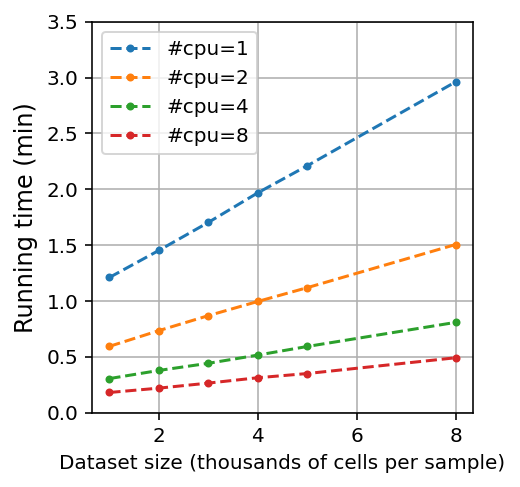

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))

x = [1e3, 2e3, 3e3, 4e3, 5e3, 8e3]
ax.plot(x, [x / 60 for x in timing_res[1]], label='#cpu=1', linestyle='--', marker=".")
ax.plot(x, [x / 60 for x in timing_res[2]], label='#cpu=2', linestyle='--', marker=".")
ax.plot(x, [x / 60 for x in timing_res[4]], label='#cpu=4', linestyle='--', marker=".")
ax.plot(x, [x / 60 for x in timing_res[8]], label='#cpu=8', linestyle='--', marker=".")

ax.set_xlabel("Dataset size (thousands of cells per sample)", fontsize=10)
ax.set_ylabel("Running time (min)", fontsize=12)
ax.set_ylim([0, 3.5])
ax.set_xticks([2000, 4000, 6000, 8000])
ax.set_xticklabels([2, 4, 6, 8])
ax.legend(loc='upper left')
ax.grid(":")

plt.tight_layout()
plt.show()